***
Welcome! 

In this session we are going to build our  model and classify some text based on its sentiment.
We will use a tagged corpus of Movie Reviews to train our model and classify unseen examples, trying to predict if a movie review is positive or negative.

We will rely on the scikit-learn library that has some relevant implementation of a Logistic Regression, the first technique we will use to classify our text. Also, we'll test with `NaiveBayes`, another type of classifier.
<br>
We will also talk about how we can create features that represent our text.
***

### Index:

[1.1 - Loading the Data](#1.1---Loading-the-Data)
<br>
[1.2 - Pre-process Text](#1.2---Pre-process-Text)
<br>
[1.3 - Log Ratio of Words](#1.3---Log-Ratio-of-Words)
<br>
[1.4 - Vectorizing Sentences (Text Representation)](#1.4---Vectorizing-Sentences-(Text-Representation))
<br>
[2 - Training Model](#2---Training-Model)



In [106]:
# NLTK Stands for Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy

# Import OS Library
import os

# Import string library
import string

# Import pandas
import pandas as pd
# Supress warnings
pd.options.mode.chained_assignment = None 

# Supress scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})


# Import numpy
import numpy as np

# Import math
import math

# Import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import (
    CountVectorizer
)

import warnings
warnings.filterwarnings('ignore')

## 1 - Preparing Features

### 1.1 - Loading the Data

First, we will load 1000 positive reviews and 1000 negative reviews:

In [2]:
neg_files = os.listdir('data/neg')
pos_files = os.listdir('data/pos')

In [3]:
def get_reviews(directory, file_list):
    files=[]
    for file in file_list:
        f = open('data/'+directory+'/'+file, "r")
        #append each line in the file to a list
        files.append(f.read())
        f.close()
        
    return files

In [4]:
negative_files = get_reviews('neg', neg_files)
positive_files = get_reviews('pos', pos_files)

Let's see some examples of some negative reviews:

In [5]:
print(negative_files[1])

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

In [6]:
print(negative_files[2])

it is movies like these that make a jaded movie viewer thankful for the invention of the timex indiglo watch . 
based on the late 1960's television show by the same name , the mod squad tells the tale of three reformed criminals under the employ of the police to go undercover . 
however , things go wrong as evidence gets stolen and they are immediately under suspicion . 
of course , the ads make it seem like so much more . 
quick cuts , cool music , claire dane's nice hair and cute outfits , car chases , stuff blowing up , and the like . 
sounds like a cool movie , does it not ? 
after the first fifteen minutes , it quickly becomes apparent that it is not . 
the mod squad is certainly a slick looking production , complete with nice hair and costumes , but that simply isn't enough . 
the film is best described as a cross between an hour-long cop show and a music video , both stretched out into the span of an hour and a half . 
and with it comes every single clich ? . 
it doesn't really 

And some positive ones:

In [7]:
print(positive_files[2])

you've got mail works alot better than it deserves to . 
in order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . 
no real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . 
essentially , it goes against and defies all concepts of good contemporary filmmaking . 
it's overly sentimental and at times terribly mushy , not to mention very manipulative . 
but oh , how enjoyable that manipulation is . 
but there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . 
it couldn't have been the directing , because both films were helmed by the same woman . 
i haven't quite yet figured out what i like

In [8]:
print(positive_files[1])

every now and then a movie comes along from a suspect studio , with every indication that it will be a stinker , and to everybody's surprise ( perhaps even the studio ) the film becomes a critical darling . 
mtv films' _election , a high school comedy starring matthew broderick and reese witherspoon , is a current example . 
did anybody know this film existed a week before it opened ? 
the plot is deceptively simple . 
george washington carver high school is having student elections . 
tracy flick ( reese witherspoon ) is an over-achiever with her hand raised at nearly every question , way , way , high . 
mr . " m " ( matthew broderick ) , sick of the megalomaniac student , encourages paul , a popular-but-slow jock to run . 
and paul's nihilistic sister jumps in the race as well , for personal reasons . 
the dark side of such sleeper success is that , because expectations were so low going in , the fact that this was quality stuff made the reviews even more enthusiastic than they have 

We know, beforehand that these are positive and negative reviews. The goal of the algorithm that we will develop is to classify **new reviews** with a certain probability of being positive / negative.

### 1.2 - Pre-process Text

As we've learned, it's relevant to pre-process our text with some of the techniques we've learned so far. Here's the pipeline that we will develop before doing any vectorization:
* Lowercase text.
* Remove punctuation
* Tokenize our reviews.
* Remove stop words.
* Stem our words.

In [9]:
positive_files =[file.lower() for file in positive_files]
negative_files =[file.lower() for file in negative_files]

Let's build a function that removes the punctuation from our text:

In [10]:
def remove_punct(list_of_text):
    
    no_punct = []
    
    for index, file in enumerate(list_of_text):
        file = (
            file.translate(
                str.maketrans('', '', string.punctuation)
            )
        )

        no_punct.append(file)
    return no_punct

In [11]:
positive_files = remove_punct(positive_files)
negative_files = remove_punct(negative_files)

Removing the stop words:

In [12]:
stop_words = stopwords.words('english')

In [13]:
stop_words[1:10]

['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
positive_files_tokenized = [word_tokenize(file) for file in positive_files]
negative_files_tokenized = [word_tokenize(file) for file in negative_files]

In [15]:
def remove_stop_words(tokenized_text):
    '''
    Removes stop words from the input tokenized text.
    The input tokenized text is passed in list format.
    '''
    stop_words = stopwords.words('english')
    
    list_files_no_stop = []
    
    for file in tokenized_text:
        no_stop_words = []
        for word in file:
            if word not in stop_words:
                no_stop_words.append(word)
        
        list_files_no_stop.append(
            no_stop_words
        )
        
    return list_files_no_stop

In [16]:
positive_files_tokenized = remove_stop_words(positive_files_tokenized)
negative_files_tokenized = remove_stop_words(negative_files_tokenized)

Before stemming, let's do some analytics on our positive and negative reviews by calculating the log ratio of most common words in positive and negative reviews. This is a common metric that people use to analyze the importance of certain features when classifying text.

In [17]:
# Let's flat our list into words:
flat_list_positive = [
    item for sublist in positive_files_tokenized for item in sublist
]

In [18]:
print('We have {} words in our positive files - {} are distinct'
      .format(len(flat_list_positive), len(set(flat_list_positive))))

We have 374637 words in our positive files - 34778 are distinct


In [19]:
# Let's flat our list into words:
flat_list_negative = [
    item for sublist in negative_files_tokenized for item in sublist
]

In [20]:
print('We have {} words in our positive files - {} are distinct'
      .format(len(flat_list_negative), len(set(flat_list_negative))))

We have 335156 words in our positive files - 32599 are distinct


### 1.3 - Log Ratio of Words

We can rely on Freq Dist to check the most relevant words for positive and negative reviews:

In [21]:
nltk.FreqDist(flat_list_negative).most_common(20)

[('film', 3994),
 ('movie', 3048),
 ('one', 2617),
 ('like', 1835),
 ('even', 1381),
 ('good', 1127),
 ('time', 1112),
 ('would', 1049),
 ('get', 1037),
 ('bad', 1019),
 ('much', 997),
 ('characters', 909),
 ('films', 903),
 ('story', 903),
 ('character', 893),
 ('plot', 876),
 ('two', 865),
 ('make', 818),
 ('first', 805),
 ('really', 787)]

In [22]:
nltk.FreqDist(flat_list_positive).most_common(20)

[('film', 4855),
 ('one', 2903),
 ('movie', 2392),
 ('like', 1716),
 ('story', 1212),
 ('films', 1198),
 ('also', 1197),
 ('good', 1191),
 ('even', 1174),
 ('time', 1171),
 ('characters', 1038),
 ('much', 1024),
 ('character', 1010),
 ('would', 993),
 ('life', 983),
 ('well', 967),
 ('first', 963),
 ('two', 960),
 ('see', 952),
 ('way', 913)]

In [23]:
negative_freq = pd.DataFrame(
    nltk.FreqDist(flat_list_negative).values(), 
    index=nltk.FreqDist(flat_list_negative).keys(),
    columns=['word_count_negative']
)
positive_freq = pd.DataFrame(
    nltk.FreqDist(flat_list_positive).values(), 
    index=nltk.FreqDist(flat_list_positive).keys(),
    columns=['word_count_positive']
)

In [24]:
word_sentiment = negative_freq.join(positive_freq).fillna(0)

Let's calculate the Log Ratio between Positive and Negative Words

In [25]:
word_sentiment['ratio'] = (
    np.log(
        word_sentiment.word_count_positive
        /word_sentiment.word_count_negative
    )
)

We can now check which words are more relevant for positive and negative reviews. Top words for negative reviews are:

In [26]:
word_sentiment.loc[
    word_sentiment.word_count_negative + word_sentiment.word_count_positive > 100 
].sort_values(by='ratio').head(10)

,word_count_negative,word_count_positive,ratio
godzilla,116,14.0,-2.114533
wasted,101,16.0,-1.842532
lame,90,15.0,-1.791759
waste,121,22.0,-1.704748
worst,259,48.0,-1.685627
ridiculous,117,22.0,-1.671131
awful,109,21.0,-1.646825
stupid,207,44.0,-1.548529
dull,110,24.0,-1.522427
boring,217,52.0,-1.428654


In [27]:
word_sentiment.loc[
    word_sentiment.word_count_negative + word_sentiment.word_count_positive > 100 
].sort_values(by='ratio').tail(10)

,word_count_negative,word_count_positive,ratio
political,31,118.0,1.336697
excellent,37,145.0,1.365816
terrific,24,96.0,1.386294
memorable,29,117.0,1.394878
pulp,21,86.0,1.409825
jackie,47,209.0,1.492187
cameron,22,106.0,1.572397
toy,17,87.0,1.632695
titanic,18,105.0,1.763589
truman,11,121.0,2.397895


### 1.4 - Vectorizing Sentences (Text Representation)

In this part of the notebook, we'll do two versions of text representation: 
* Representing our text with a CountVectorizer using the `stems` of the original tokens.
* Representing our words as the average of the word vectors (using `spacy`). In this case, we will not stem the tokens.

These two concurrent approaches will be used to train our algorithm.

Let's start by doing the CountVectorizer of the stems:

In [28]:
def stem_sentence(tokenized_sentence):
    stemmer = PorterStemmer()
    stem_sentence = []
    for word in tokenized_sentence:
        stem_sentence.append(stemmer.stem(word))
        
    return stem_sentence

stemmed_negative_files = [
    stem_sentence(sentence) for sentence in negative_files_tokenized
]
stemmed_positive_files = [
    stem_sentence(sentence) for sentence in positive_files_tokenized
]

sentence_negative = [' '.join(file) for file in stemmed_negative_files]
sentence_positive = [' '.join(file) for file in stemmed_positive_files]

sentence_negative = pd.DataFrame(sentence_negative, columns=['sentence'])
sentence_positive = pd.DataFrame(sentence_positive, columns=['sentence'])

In [29]:
sentence_positive.head(10)

,sentence
0,film adapt comic book plenti success whether t...
1,everi movi come along suspect studio everi ind...
2,youv got mail work alot better deserv order ma...
3,jaw rare film grab attent show singl imag scre...
4,moviemak lot like gener manag nfl team postsal...
5,june 30 1960 selftaught idealist yet pragmat y...
6,appar director toni kay major battl new line r...
7,one colleagu surpris told will see betsi wed s...
8,bloodi clash independ lumumba refus pander bel...
9,american action film slowli drown death sea as...


Creating the full vectorizer of positive and negative sentences:

In [30]:
training_base = sentence_positive.append(sentence_negative).reset_index(drop=True)

cv = CountVectorizer(binary=True)
X = cv.fit_transform(training_base.sentence).todense()
X = pd.DataFrame(
    X,
    columns=cv.get_feature_names_out()
)

We have our `X` - commonly called the features of the algorithm. Let's also develop an alternative version of these features by using spacy's NLP and extracting the fixed-size lenght vectors.

In [31]:
nlp = spacy.load("en_core_web_md")

Our y consists of labels with zeros and one's - 1 for positive reviews and 0 for negative reviews. **This is commonly known in Machine Learning as the "target variable".**

In [32]:
nlp_vectors_neg = [nlp(sentence).vector for sentence in negative_files]
nlp_vectors_pos = [nlp(sentence).vector for sentence in positive_files]

In [33]:
X_2 = (np.vstack([nlp_vectors_pos,nlp_vectors_neg]))

Our `X_2` is a collection of all document vectors with 300 dimensions:

In [34]:
X_2.shape

(2001, 300)

Only the target left! We represent our target using `y` with 1 for positive sentiment and 0 for negative.

In [35]:
y = np.append(np.ones(1000), np.zeros(1001))

First 1000 reviews are positive so they will have target 1:

In [36]:
y[0:1000]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

All other reviews have target 0, being negative:

In [37]:
y[1001:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 2 - Training a Model

### 2.1 Training Process

We have a classification problem in our hands (other common problem in Machine Learning is a regression problem, that consists of a continuous target variable.) - Let's understand the first algorithm we will test, logistic regression and comparing it with linear regression (suitable for regression problems):

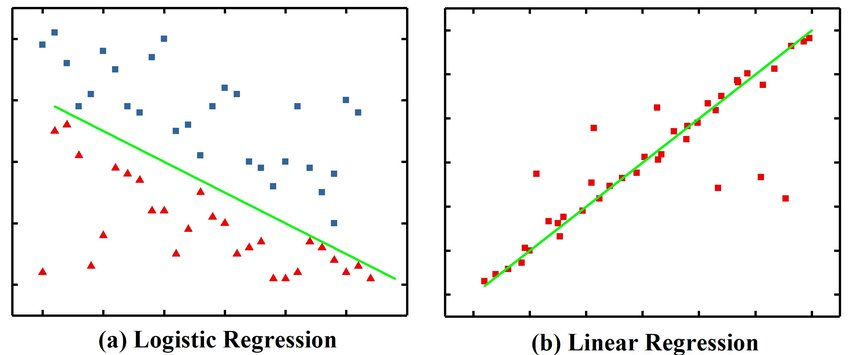

source:https://www.researchgate.net/figure/Logistic-regression-and-linear-regression_fig1_335786324

A logistic regression **(a)** has the goal of separating two or more classes based on specific variables (or features, in this case the dimensionality of our vectors). This algorithm is a linear algorithm, meaning that it can't solve a problem similar to the one on the next figure as there is no perfect boundary that can't separate the two classes:

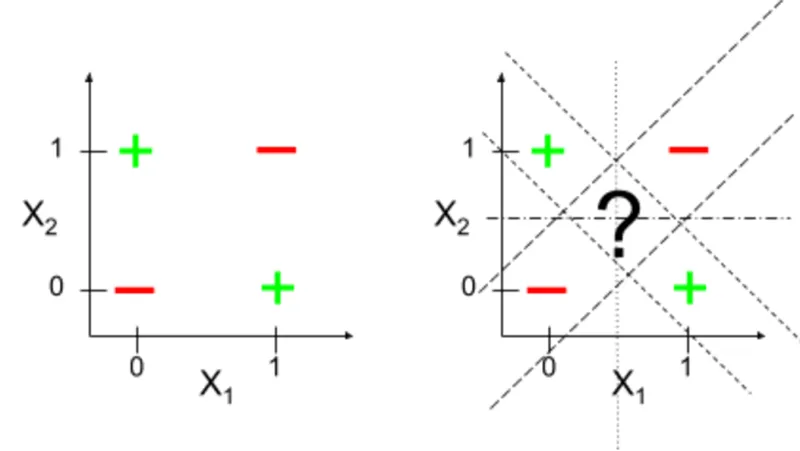

Even so, logistic regression is used widely due to it's simplicity, adaptability and explainability. But, how exactly is the model trained?

The model is trained (similarly to other algorithms) in machine learning using the concept of "error minimization". What do we want to do in this case? Minimize the error of our predictions (i.e. predicting that a review is positive when it is negative and vice-versa) - so our objective is to minimize this error during training based on "weights" that we give to the input variables. (similar to the example we've done with a Neural Network).
<br>
<br>
We start at an arbitrary point and then descend towards a minimum error based on changing the parameters. **Let's see this visually and imagining we just had one feature in our model:**

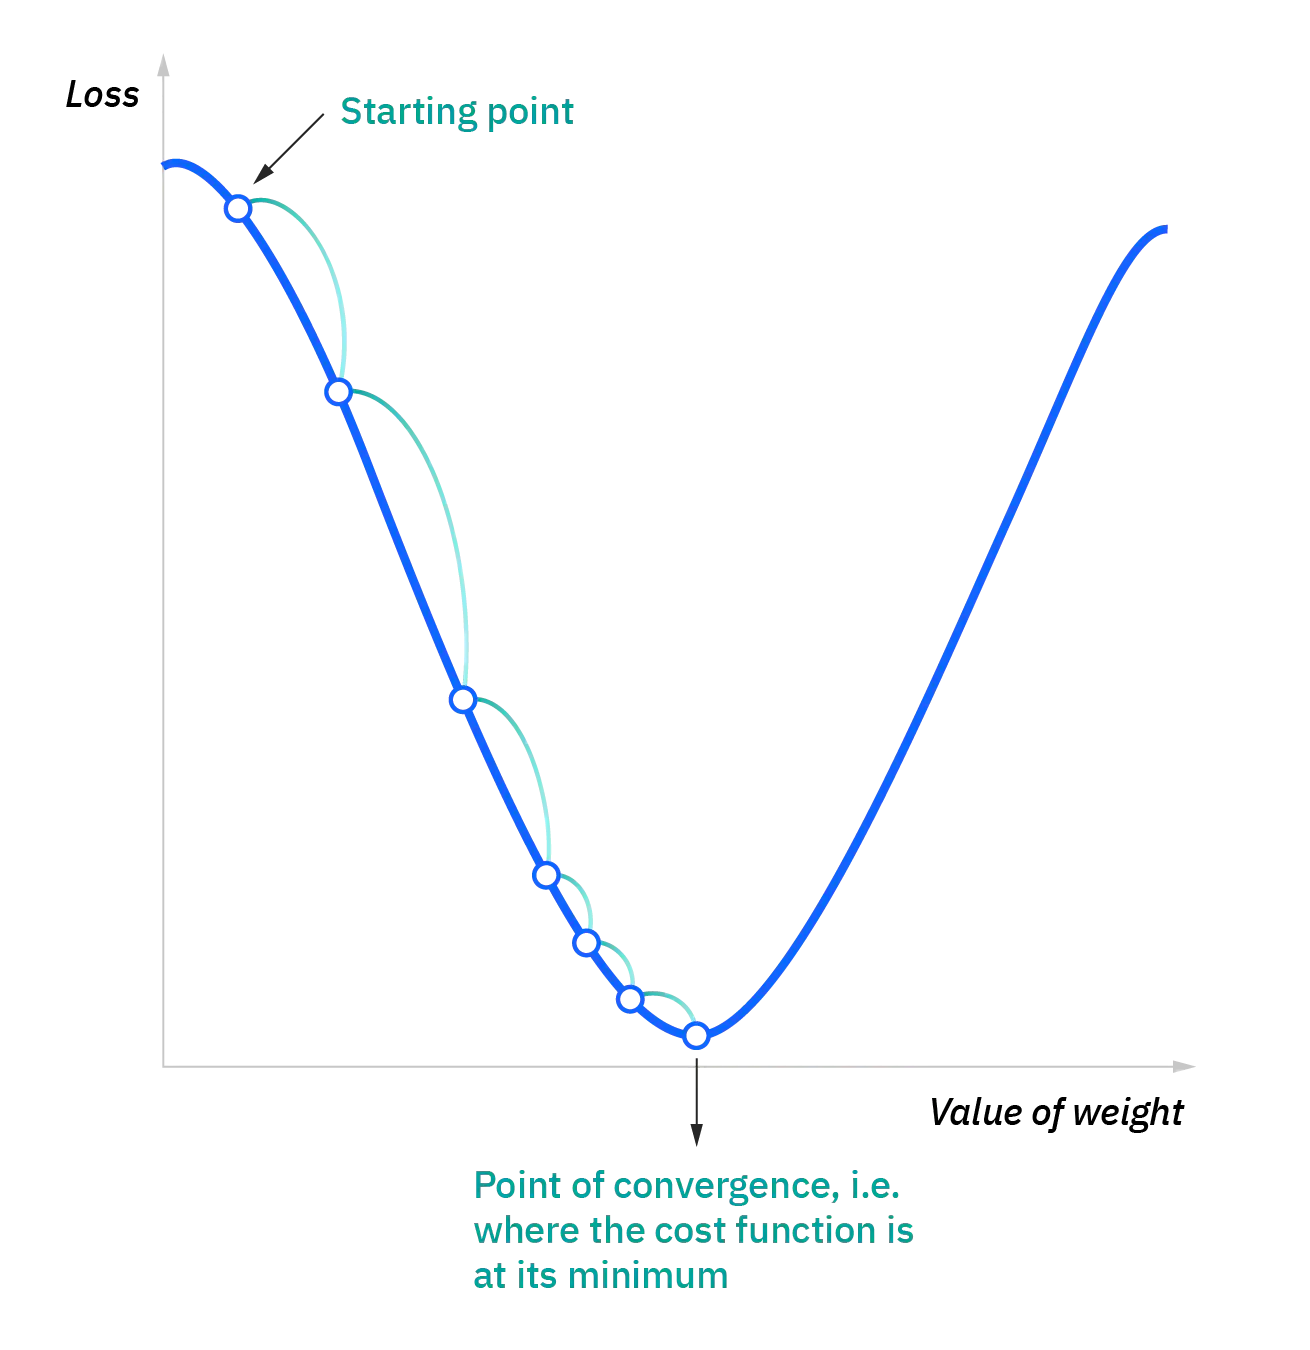

*source: https://www.ibm.com/cloud/learn/gradient-descent*

In the plot above consider the following:
- On the y-axis the "Loss" is our average error - in our case the difference between the target (1 or 0) and what our algorithm is predicting.
- On the x-axis imagine that the Value of Weight is the weight we are going to give the word `"worst"` in our model. This word be the only variable we will use in our first training example.
<br>


If you randomnly try different weights for the word `"worst"` in our reviews and take that weight into account to output the probability of a review being positive or not, we will have different error values depending on that weight. Let's test that, using our reviews! 

In [38]:
# Let's subset a single feature for our model - the column that states
# if the review contains the word worst or not
feature = X['worst']

In [39]:
feature.head(50)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: worst, dtype: int64

From the first 50 reviews, only review number 21 contains the word `worst`.

Now, if I multiply the value of the feature by some arbitrary value we will have a new value. We will start to multiply our variable by 1.2 and this will be our first random weight.

In [40]:
feature_weight = feature*1.2

In [41]:
feature_weight.head(50)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    1.2
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
Name: worst, dtype: float64

Notice that the feature weight now has values that range from 0 to 1.2 - but our target is between 0 and 1? If the resulting output of this simple model is 1.2 and we want to classify our target between 0 and 1 (Positive = 1 and Negative = 0), 1.2 is outside the boundary.
<br>
<br>
This is where we will use a concept we've already learn - the sigmoid function!

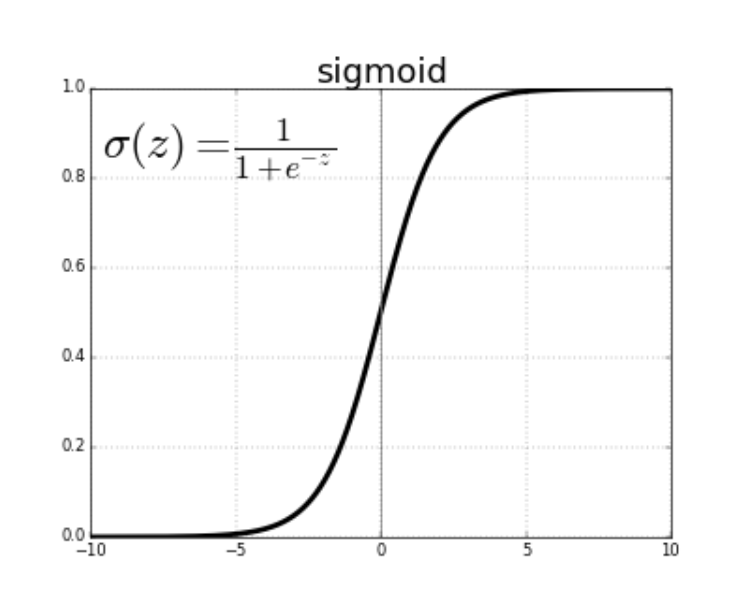

The sigmoid is a function that gets any value and positions it between 0 and 1. Notice how 0 on the input of the sigmoid will output 0.5 - this is basically a neutral position of the function. In our case, we would say that there is 50% chance that the review is negative and 50% chance that the review is positive.
<br>
<br>
*Note: Logistic regression does not output a pure probability but it is helpful to think that it is.*
<br>
<br>
Let's now pass our feature output value on the sigmoid function - we will need the `math` module here:

In [42]:
1/(1+math.e**(-feature_weight))

0       0.5
1       0.5
2       0.5
3       0.5
4       0.5
       ... 
1996    0.5
1997    0.5
1998    0.5
1999    0.5
2000    0.5
Name: worst, Length: 2001, dtype: float64

As we have a lot of 0's, and these 0's do not carry much information, only absence of the word - the majority of reviews will be labeled as neither positive nor negative (0.5).

We just extracted a proxy for the probability of a review being positive! Values next to 1 mean that that specific review has a higher probability of being positive. To simplify, we'll assume that every review that has a value of over 0.5 has a higher probability of being positive. Otherwise, we will say that the review is going to be negative:

In [43]:
model_output = 1/(1+math.e**(-feature_weight))

In [44]:
np.round(model_output).head(30)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    1.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
Name: worst, dtype: float64

Now we can compare this output with the real values of positive and negative reviews:

In [45]:
predicted_target = np.round(model_output)

In [46]:
predicted_target==y

0       False
1       False
2       False
3       False
4       False
        ...  
1996     True
1997     True
1998     True
1999     True
2000     True
Name: worst, Length: 2001, dtype: bool

`False` means we are not predicting the correct target and `True` means that we are. 
<br>
<br>
Notice that as 0.5 is being assigned to 0 we are predicting more Negative reviews with the correct label just by randomness. In an ML model with a lot of variables, the probability that you will have an output exactly equals to 0.5 is quite low.

Let's compute our accuracy (remember the loss that we spoke on the gradient descent? It's related to accuracy, although we call it `categorical_crossentropy`)!

In [47]:
(predicted_target==y).sum()/2000

0.425

With this simple model we are predicting 42.45% reviews correctly.

That's bad. Why? because if we predicted every review as negative we would get 50% correct labels. Let's then update our value from the weight in our model.
<br>
<br>
We know that the word **worst** is more relevant to negative reviews - so probably it would be a good idea to assign a negative weight (check the sigmoid function!) here.

In [48]:
feature_weight_new_model = feature*-1.2
model_output_new_model = 1/(1+math.e**(-feature_weight_new_model))
predicted_target_new_model = np.round(model_output_new_model)

In [49]:
(predicted_target_new_model==y).sum()/2000

0.5005

Ok, cool! We were able to improve our model just by tweaking the weight to -1.2. We have done a manually approach to gradient descent! Let's do a final experiment with two variables - the word **worst** and the word **truman**:

In [50]:
features = X[['worst', 'truman']]

Now let's multiply worst by -1.2 and truman by 1.2:

In [51]:
features['worst'] = features['worst']*-1.2
features['truman'] = features['truman']*1.2

In [52]:
features

,worst,truman
0,-0.0,0.0
1,-0.0,0.0
2,-0.0,0.0
3,-0.0,0.0
4,-0.0,0.0
...,...,...
1996,-0.0,0.0
1997,-0.0,0.0
1998,-0.0,0.0
1999,-0.0,0.0


In [53]:
features.sum(axis=1)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1996    0.0
1997    0.0
1998    0.0
1999    0.0
2000    0.0
Length: 2001, dtype: float64

How to pass two features to the sigmoid? By summing the weighted values!

In [54]:
model_output_two_features = 1/(1+math.e**(-features.sum(axis=1)))

We have a new predicted probability:

In [55]:
model_output_two_features

0       0.5
1       0.5
2       0.5
3       0.5
4       0.5
       ... 
1996    0.5
1997    0.5
1998    0.5
1999    0.5
2000    0.5
Length: 2001, dtype: float64

In [56]:
(np.round(model_output_two_features)==y).sum()/2000

0.506

We've successfuly improved our classification with the new feature (although just a tiny bit)!

In [57]:
X.shape

(2001, 31901)

Remember that we have about 31.901 features for our potential model, doing this manually would be near impossible. We can use the Logistic Regression function from the `sklearn` library to do this for us!

In [58]:
X.columns

Index(['00', '000', '0009f', '000acr', '000aweek', '000foot', '000paltri',
       '007', '007esqu', '010',
       ...
       'zuehlk', 'zuko', 'zukovski', 'zulu', 'zundel', 'zurg', 'zweibel',
       'zwick', 'zwigoff', 'zyci'],
      dtype='object', length=31901)

With the `CountVectorizer`, we were able to use the logic behind the log-ratio to extract features that we knew would improve our algorithm (`truman` and `worst`). With the word vectors approach, we hope that the word vectors will have this information but hidden inside the 300-dimensional vector, but it's harder to interpret what each individual column will represent.

### 2.2 Training Process

Another important step that we should know is that we should never evaluate our trained algorithm on the same data that we have trained it on. This will lead to problems with our algorithm adapting "too well" to the training dataset and performing poorly on new data.
<br>
<br>
This is a really important concept known as **overfitting** - to guarantee that there is a low likelihood of this happening in our model, we have to evaluate our algorithm in a sample that is not going to be fed to the training process (and being utilized to improve the weights).

In real world projects and when we have more rows, we may do this with even more datasets that are not used during the training process.

<br> Let's then select 100 positive and 100 negative reviews that will be used just for evaluation. The idea is that we will test that the weights we've found are able to correctly guess the sentiment of these reviews without using them in the training process.

In [59]:
X_test = X[0:100].append(X[-100:])
y_test = np.append(y[0:100],y[-100:])

And now selecting our training set, which will contain 1801 reviews:

In [60]:
X_train = X[100:len(X)-100]
y_train = y[100:len(y)-100]

Note that with our huge dimensional space we have more probability of overfitting our algorithm. Let's train our model with these features first:

In [61]:
lm_count_vectorizer = LogisticRegression(random_state=1234)

In [62]:
lm_count_vectorizer.fit(X_train, y_train)

LogisticRegression(random_state=1234)

Let's check the `accuracy` on our train_set first - we can use the predict method to predict using our trained model:

In [63]:
y_pred = lm_count_vectorizer.predict(X_train)

In [64]:
((y_pred == y_train).sum())/len(y_train)

1.0

Our accuracy is 100% on the training set. This is a result that is showing us that we are overfitting our hypothesis.  The weights we've found adjust perfectly to our training set and that is, generally, a bad sign.
<br>
<br>
As discussed, to really evaluate the performance of our algorithm, we have to check the accuracy in the test set. The rows that we left out of this training process and that mimic the real world that the algorithm should find. **This is one of the most common errors that data science rookies make: assuming that because your algorithm achieves 100% accuracy in the training set you have a good model.** 

In [65]:
y_pred_test = lm_count_vectorizer.predict(X_test)

In [66]:
(y_pred_test == y_test).sum()/len(y_test)

0.86

As you can see, our model behaves generally well, but in the test set it is able to achieve 87% accuracy. This is what we should expect if we put this model in production.
<br>
<br>
Having this difference in accuracy between training and test datasets is not optimum as it may lead to a quicker accuracy drift. We can reduce overfitting by:
* Reducing the number of features.
* Changing the type of model.
* Doing a technique called regularization.

Let's try the first two. To reduce the number of features, we can pick up our vectorizer with the document vectors and use that as `x_train`!

In [67]:
X_train_2 = X_2[100:len(X_2)-100]
X_test_2 = np.vstack([X_2[0:100],X_2[-100:]])

In [68]:
lm_wordvec = LogisticRegression(random_state=1234)

In [69]:
lm_wordvec.fit(X_train_2, y_train)

LogisticRegression(random_state=1234)

In [70]:
y_pred_wordvec = lm_wordvec.predict(X_train_2)

In [71]:
((y_pred_wordvec == y_train).sum())/len(y_train)

0.8573014991671294

In [72]:
y_pred_test_wordvec = lm_wordvec.predict(X_test_2)

In [73]:
((y_pred_test_wordvec == y_test).sum())/len(y_test)

0.805

Another common way to evaluate the results of classification models is to use a `ConfusionMatrix`:

In [74]:
from sklearn.metrics import confusion_matrix

In [75]:
cm = confusion_matrix(y_test, y_pred_test)

In [76]:
pd.DataFrame(
    cm,
    columns = ['Predicted Positive', 'Predicted Negative'],
    index = ['Positive Reviews', 'Negative Reviews']
)

,Predicted Positive,Predicted Negative
Positive Reviews,84,16
Negative Reviews,23,77


Notice that, although our train and test set accuracies are lower with word vectors, the difference between training and test set is lower than in the solution with `CountVectorizer`. This will make your model a bit more stable when you want to productize it and use it with "real" new data.

In [77]:
# Some metrics we can extract from the confusion matrix: 
TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

# Calculate Precision, Recall, and F1 Score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Display using .format()
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))

Precision: 0.83
Recall: 0.77
F1 Score: 0.80


### 2.3 Training Process using Naive Bayes Classifier

Let's see the performance of our model if we train a Naive Bayes Classifier:

In [78]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [84]:
y_pred_nb_train = nb.predict(X_train)
y_pred_nb = nb.predict(X_test)

In [83]:
((y_pred_nb == y_test).sum())/len(y_test)

0.855

In [85]:
((y_pred_nb_train == y_train).sum())/len(y_train)

0.9800111049416991

And checking the performance with Word2Vec vectorizer - `MultinomialNB` can't handle negative values so we need to use `GaussianNB`:

In [90]:
nb_vec = GaussianNB()
nb_vec.fit(X_train_2, y_train)

GaussianNB()

In [91]:
y_pred_gnb_train = nb_vec.predict(X_train_2)
y_pred_gnb = nb_vec.predict(X_test_2)

In [92]:
((y_pred_gnb == y_test).sum())/len(y_test)

0.635

In [93]:
((y_pred_gnb_train == y_train).sum())/len(y_train)

0.6490838423098279

Why such a low performance? GaussianNB assumes that there is a normal distribution on the features - we can't guarantee that with the Word2Vec weights!

In [115]:
nb.predict_proba(X_test.iloc[5].values.reshape(1, -1))

array([[0.00, 1.00]])

# 3. Classifying New Reviews

Let's use some of the models we've developed to classify new reviews. In this part of the notebook, we'll use some reviews about recent movies that were not on the training base, and see how our models are able to classify the sentiment.

In [117]:
new_review = """Interstellar is nothing short of a cinematic masterpiece. 
Christopher Nolan's foray into the vast expanse of the cosmos is both visually stunning 
and emotionally resonant. The film's grandiose depictions of distant galaxies and 
black holes are unparalleled, making viewers feel as though they are truly journeying 
through the stars alongside the film's intrepid astronauts. Yet, at its heart,
"Interstellar" remains a profoundly human story, exploring the unbreakable bonds 
of love and the lengths to which we will go to safeguard the future of our loved ones. 
Hans Zimmer's hauntingly beautiful score perfectly complements the film's visual splendor, 
evoking a sense of wonder and melancholy in equal measure. In an age of formulaic blockbusters, 
"Interstellar" stands out as a bold and thought-provoking epic that challenges, mesmerizes, 
and ultimately uplifts. A must-watch for all who believe in the boundless potential of 
the human spirit."""

**We need to use exactly the same pipeline (that we've done in the training process) for the new review!**

In [149]:
def pipeline(review_to_process):
    
    review_preprocessed = remove_punct([review_to_process.lower()])
    tokenized_review = word_tokenize(review_preprocessed[0])
    stemmer = PorterStemmer()

    stemmed_review = [stemmer.stem(word) for word in tokenized_review]

    # We need to transform because we need to use the vocab from
    # the training process
    vectorized_review = cv.transform([' '.join(stemmed_review)])
    
    return vectorized_review

vectorized_review = pipeline(new_review)

In [147]:
# Let's predict the sentiment
lm_count_vectorizer.predict_proba(vectorized_review)

array([[0.02, 0.98]])

On the left, we have the probability of the review having negative sentiment - on the right, we have the opposite, the probability that it is positive.

Our model is predicting that this review has 98% probability of being a positive review! Here, we've used the `LogisticRegression` with the `CountVectorizer`.

Let's see what happens when we have a neutral review:

In [148]:
neutral_review = """Toy Story 3 continues Pixar's beloved franchise, taking our favorite toys on yet another adventure as they grapple with the inevitability of change and growing up. The animation remains top-notch, and the voice acting brings familiar warmth to these well-known characters. While the narrative hits many of the emotional beats one would expect, especially in its portrayal of the bond between toys and their owner, some may feel it treads familiar ground. It serves as a suitable sequel that fans of the series will appreciate, even if it doesn't quite capture the groundbreaking magic of its predecessors. Overall, a decent watch that adds another chapter to Woody, Buzz, and the gang's ongoing saga."""

In [150]:
vectorized_review_neutral = pipeline(neutral_review)

In [151]:
# Let's predict the sentiment
lm_count_vectorizer.predict_proba(vectorized_review_neutral)

array([[0.07, 0.93]])

Let's see what happens with a negative review:

In [164]:
negative_review = '''
Christopher Nolan's ambitious space epic, "Interstellar", strives for the stars, but ultimately crash-lands into a black hole of convoluted storytelling. While it cannot be denied that the film boasts stellar visuals and some genuinely heart-pounding sequences, it's overshadowed by its attempts to intertwine quantum physics with human drama. The result? An overly complex narrative that often confuses more than it clarifies.

The film's runtime is bloated, meandering through subplots that could've been tightened or removed altogether. Nolan’s infatuation with thematic grandiosity detracts from the simplicity of a father-daughter relationship, which should've been the film's beating heart.

Matthew McConaughey delivers a commendable performance, but even he can't save the jumbled dialogue, some of which sounds like it was lifted directly from a physics textbook. Meanwhile, other characters are woefully underdeveloped, serving little more than exposition mouthpieces.

Hans Zimmer's score, though epic in places, is often so overbearing that it drowns out pivotal dialogue, making key moments feel more like a rock concert than a meaningful cinematic experience.

In the end, "Interstellar" could have been a thought-provoking exploration of space, time, and love. Instead, it feels like a missed opportunity, lost in its own labyrinthine ambitions.
'''

In [171]:
vectorized_review_negative = pipeline(negative_review)

In [172]:
# Let's predict the sentiment
lm_count_vectorizer.predict_proba(vectorized_review_negative)

array([[0.79, 0.21]])

In [175]:
negative_wordvec = nlp(negative_review.lower()).vector

In [177]:
# Let's predict the sentiment
lm_wordvec.predict_proba(negative_wordvec.reshape(1, -1))

array([[0.88, 0.12]])

And finally, a neutral example:

In [179]:
neutral_review = """
"Interstellar" stands as one of Christopher Nolan's most ambitious undertakings. The film takes us on a grand journey through space, time, and the complexities of human emotions, presenting a mixed bag that will resonate differently for various viewers.

On one hand, its visuals are undeniably captivating. Nolan's depiction of outer space and the celestial bodies beyond our galaxy showcases the film's commitment to delivering a genuine spectacle. However, for every breathtaking shot, there seems to be a sequence that drags on a bit too long, leading to a somewhat uneven pacing.

The cast, led by Matthew McConaughey, delivers competent performances. Yet, the depth of their characters varies. While the central relationship between a father and his daughter is explored in depth, some supporting characters feel more like tools for exposition than fleshed-out individuals.

The soundtrack by Hans Zimmer is both a blessing and a curse. There are moments when it elevates the narrative, inducing goosebumps, and there are instances where it feels overwhelming, slightly overshadowing the dialogue.

In essence, "Interstellar" offers a lot to ponder and appreciate. But it equally provides moments that may leave you scratching your head or glancing at your watch. It's a cinematic experience that's neither groundbreaking nor forgettable—a journey worth taking, but with tempered expectations.
"""

In [181]:
vectorized_review_neutral = pipeline(neutral_review)
neutral_wordvec = nlp(neutral_review.lower()).vector

In [182]:
lm_count_vectorizer.predict_proba(vectorized_review_neutral)

array([[0.01, 0.99]])

In [185]:
lm_wordvec.predict_proba(neutral_wordvec.reshape(1, -1))

array([[0.01, 0.99]])

Unfortunately, both models are not very good at targeting neutral reviews. Mostly, this happens because we don't have this target in the training data - if you want to explicitly add "neutral" review, it would be helpful to add that class of review to the training base so that the model was able to understand which words were important for those types of reviews.